NBEATS EXAMPLE

https://subhayo.wordpress.com/2019/05/15/time-series-analysis-of-monthly-milk-production/

It's a toy example to show how to do time series forecasting using N-Beats.

In [2]:
import sys
import os

# Thêm đường dẫn thư mục cha chứa nbeats_pytorch vào PYTHONPATH
sys.path.append(os.path.abspath('..'))

In [3]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import torch
from torch    import optim
from torch.nn import functional as F

from nbeats_pytorch.model import NBeatsNet
from trainer_pytorch      import save

warnings.filterwarnings(action='ignore', message='Setting attributes')

In [4]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x, y, size):
    assert len(x) == len(y)
    batches = []
    for ii in range(0, len(x), size):
        batches.append((x[ii:ii + size], y[ii:ii + size]))
    for batch in batches:
        yield batch

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @2364867725200
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @2364859334992
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=15, forecast_length=5, share_thetas=False) at @2364868882832
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @2364880012368
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @2364866033936
     | -

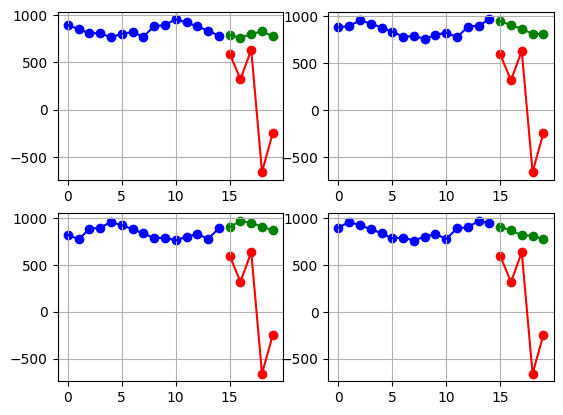

epoch = 0000, grad_step = 000012, tr_loss (epoch) = 798.551, te_loss (epoch) = 855.989


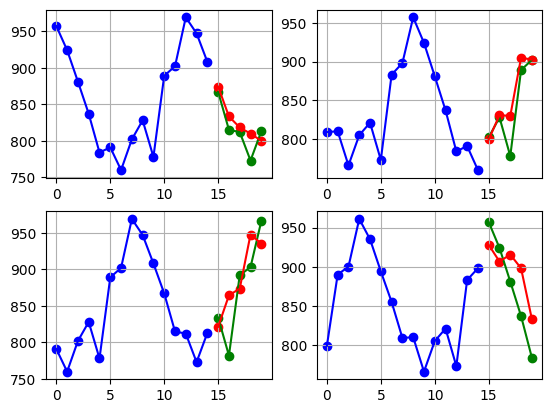

epoch = 0100, grad_step = 001212, tr_loss (epoch) = 1.016, te_loss (epoch) = 1.310


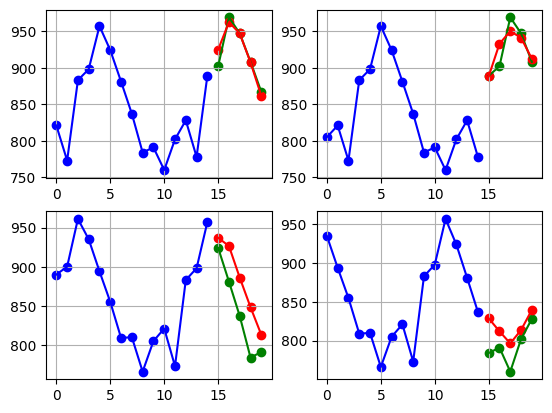

epoch = 0200, grad_step = 002412, tr_loss (epoch) = 0.587, te_loss (epoch) = 0.988


KeyboardInterrupt: 

In [5]:
def main():
    forecast_length = 5
    backcast_length = 3 * forecast_length
    batch_size      = 10  # greater than 4 for viz

    milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)
    print(milk.head())
    milk = milk.values.flatten()  # just keep np array here for simplicity.

    # data backcast/forecast generation.
    x, y = [], []
    for epoch in range(backcast_length, len(milk) - forecast_length):
        x.append(milk[epoch - backcast_length:epoch])
        y.append(milk[epoch:epoch + forecast_length])
    x = np.array(x)
    y = np.array(y)

    # split train/test.
    c                = int(len(x) * 0.8)
    x_train, y_train = x[:c], y[:c]
    x_test, y_test   = x[c:], y[c:]

    # normalization.
    norm_constant    = np.max(x_train)
    x_train, y_train = x_train / norm_constant, y_train / norm_constant
    x_test, y_test   = x_test / norm_constant, y_test / norm_constant

    # model
    net = NBeatsNet(stack_types        = (NBeatsNet.GENERIC_BLOCK, 
                                          NBeatsNet.GENERIC_BLOCK),
                    forecast_length    = forecast_length,
                    backcast_length    = backcast_length,
                    hidden_layer_units = 128,
    )
    optimiser = optim.Adam(lr=1e-4, params=net.parameters())

    grad_step = 0
    for epoch in range(1000):
        # train.
        net.train()
        train_loss = []
        for x_train_batch, y_train_batch in data_generator(x_train, y_train, batch_size):
            grad_step += 1
            optimiser.zero_grad()
            _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(net.device))
            loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(net.device))
            train_loss.append(loss.item())
            loss.backward()
            optimiser.step()
        train_loss = np.mean(train_loss)

        # test.
        net.eval()
        _, forecast = net(torch.tensor(x_test, dtype=torch.float))
        test_loss   = F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item()
        p           = forecast.detach().numpy()
        if epoch % 100 == 0:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                plot_scatter(range(0, backcast_length), xx, color='b')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
                plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
            plt.show()

            with torch.no_grad():
                save(net, optimiser, grad_step)
            print(f'epoch = {str(epoch).zfill(4)}, '
                  f'grad_step = {str(grad_step).zfill(6)}, '
                  f'tr_loss (epoch) = {1000 * train_loss:.3f}, '
                  f'te_loss (epoch) = {1000 * test_loss:.3f}')




if __name__ == '__main__':
    main()